For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week12-word-context-vectors

# Hist 3368 - Week 12: Word Context Vectors with Gensim

## Teaching Version

#### By Jo Guldi

In [1]:
import pandas as pd
import csv
import glob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt
import itertools
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

In [2]:
tokenizer = TreebankWordTokenizer()

def make_sentences(text):
    preprocessed_text = []
    for line in text:
        lower_case = line.lower()
        sentences = sent_tokenize(lower_case)
        tokenized_sentences = [tokenizer.tokenize(sent) for sent in sentences]
        preprocessed_text += tokenized_sentences
    return preprocessed_text

#### Load some Data

In [3]:
cd /scratch/group/history/hist_3368-jguldi

/scratch/group/history/hist_3368-jguldi


In [4]:
congress = pd.read_csv("congress1967-2010.csv")
all_data = congress[congress['year'] >= 1967]
all_data = congress[congress['year'] <= 1983]
#congress = pd.read_csv("eighties_data.csv")

In [5]:
all_data[:5]

,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year
0,0,0,Those who do not enjoy the privilege of the fl...,1967-01-10,The VICE PRESIDENT,16,1967,1,1967-01-01
1,1,1,Mr. President. on the basis of an agreement re...,1967-01-10,Mr. MANSFIELD,35,1967,1,1967-01-01
2,2,2,The Members of the Senate have heard the remar...,1967-01-10,The VICE PRESIDENT,40,1967,1,1967-01-01
3,3,3,The Chair lays before the Senate the following...,1967-01-10,The VICE PRESIDENT,151,1967,1,1967-01-01
4,4,4,Secretary of State.,1967-01-10,Mrs. AGNES BAGGETT,3,1967,1,1967-01-01


In [6]:
all_data['5yrperiod'] = np.floor(all_data['year'] / 5) * 5 # round each year to the nearest 5 -- by dividing by 5 and "flooring" to the lowest integer
all_data = all_data.drop(['date', 'year', 'speaker','Unnamed: 0', 'Unnamed: 0.1', 'word_count', 'month'], 1)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
all_data['index'] = np.arange(len(all_data)) # create an 'index' column

In [8]:
all_data.head()

,speech,month_year,5yrperiod,index
0,Those who do not enjoy the privilege of the fl...,1967-01-01,1965.0,0
1,Mr. President. on the basis of an agreement re...,1967-01-01,1965.0,1
2,The Members of the Senate have heard the remar...,1967-01-01,1965.0,2
3,The Chair lays before the Senate the following...,1967-01-01,1965.0,3
4,Secretary of State.,1967-01-01,1965.0,4


#### Downsample

In [9]:
sample_l = all_data.sample(500000)
sample_m = sample_l.sample(50000)
sample = sample_m.sample(5000)

## Introducing Gensim, a Tool for Studying Word Embeddings

In [14]:
sentences_m = make_sentences(sample_m['speech']).copy() # <---- switch out sample_l to all_data, sample_s or sample_m here

In [15]:
sentences_m[:2]

[['four', 'or', 'three', '?'], ['secretary', 'laird', '.']]

In [13]:
import gensim 

In [16]:
congress_model = gensim.models.Word2Vec(
    sentences = sentences_m,
    min_count = 2, # remove words stated only once
    size = 100) # size of neuralnet layers; default is 100; higher for larger corpora

In [58]:
#congress_model.save('congress_model')

In [59]:
#congress_model = gensim.models.Word2Vec.load('congress_model') 

#### Find the CONTEXT for One Word

In [17]:
man_vector = congress_model.wv['man']
congress_model.wv.similar_by_vector(man_vector)

[('man', 1.0),
 ('woman', 0.7686609625816345),
 ('lawyer', 0.7310620546340942),
 ('person', 0.7212985754013062),
 ('lady', 0.6881502866744995),
 ('politician', 0.686683177947998),
 ('mother', 0.6794568300247192),
 ('statesman', 0.6598316431045532),
 ('soldier', 0.6578181982040405),
 ('symbol', 0.6496400833129883)]

In [18]:
woman_vector = congress_model.wv['woman']
congress_model.wv.similar_by_vector(woman_vector)

[('woman', 1.0),
 ('man', 0.7686609625816345),
 ('soldier', 0.7637701630592346),
 ('doctor', 0.7353074550628662),
 ('lawyer', 0.7327905893325806),
 ('mother', 0.7296563386917114),
 ('politician', 0.7281454801559448),
 ('person', 0.7227122783660889),
 ('boy', 0.7201299667358398),
 ('lady', 0.710519552230835)]

In [19]:
individual_vector = congress_model.wv['individual']
congress_model.wv.similar_by_vector(individual_vector)

[('individual', 1.0),
 ('employee', 0.6676400303840637),
 ('employer', 0.6480520367622375),
 ('individuals', 0.6324355602264404),
 ('employers', 0.5918911695480347),
 ('property', 0.5629029870033264),
 ('applicant', 0.5574595928192139),
 ('annuity', 0.5487593412399292),
 ('voter', 0.541032612323761),
 ('equal', 0.5407780408859253)]

In [20]:
soldier_vector = congress_model.wv['soldier']
congress_model.wv.similar_by_vector(soldier_vector)

[('soldier', 1.0),
 ('patriot', 0.8046800494194031),
 ('statesman', 0.774128794670105),
 ('hero', 0.7670360803604126),
 ('woman', 0.7637701630592346),
 ('boy', 0.748926043510437),
 ('player', 0.7477824687957764),
 ('champion', 0.7353664636611938),
 ('legacy', 0.7306735515594482),
 ('lady', 0.7298756837844849)]

## Subtracting Vectors

In [79]:
diff = congress_model.wv['man'] - congress_model.wv['woman']
congress_model.wv.similar_by_vector(diff)

[('man', 0.8865554332733154),
 ('person', 0.5839686989784241),
 ('anyone', 0.5157653093338013),
 ('everyone', 0.5006527900695801),
 ('courage', 0.500137984752655),
 ('sense', 0.4854341149330139),
 ('reputation', 0.4779624938964844),
 ('legacy', 0.4758404493331909),
 ('always', 0.47562742233276367),
 ('humor', 0.4749537706375122)]

In [32]:
diff = congress_model.wv['woman'] - congress_model.wv['boy']
congress_model.wv.similar_by_vector(diff)

[('woman', 0.7777633666992188),
 ('person', 0.6597403287887573),
 ('man', 0.5670256614685059),
 ('applicant', 0.5439983606338501),
 ('lawyer', 0.5390435457229614),
 ('montanan', 0.5274957418441772),
 ('politician', 0.5264819264411926),
 ('beneficiary', 0.5089719295501709),
 ('doctor', 0.5040901899337769),
 ('illustration', 0.5018414855003357)]

### Distance and Similarity with Vectors in GENSIM

With similarity, the higher the number, the more alike two terms are in the context in which they are used. 

In [23]:
congress_model.wv.similarity('women', 'men')

0.6496907

In [22]:
congress_model.wv.similarity('soldier', 'men')

0.498866

In [21]:
congress_model.wv.similarity('women', 'individual')

0.3094792

#### Find the words most SIMILAR to each word

In [70]:
congress_model.wv.most_similar("women", topn = 20)

[('volunteers', 0.7512078285217285),
 ('men', 0.7265892624855042),
 ('families', 0.7205857038497925),
 ('disabled', 0.7204339504241943),
 ('unemployed', 0.7193293571472168),
 ('mothers', 0.7132111191749573),
 ('young', 0.6916542053222656),
 ('servicemen', 0.6882789731025696),
 ('parents', 0.687849760055542),
 ('adults', 0.6769461631774902),
 ('blacks', 0.6762923002243042),
 ('disadvantaged', 0.6728354096412659),
 ('handicapped', 0.6688811182975769),
 ('teachers', 0.6664316654205322),
 ('elderly', 0.6664093136787415),
 ('children', 0.6649971604347229),
 ('wives', 0.6639248132705688),
 ('survivors', 0.6577557921409607),
 ('poor', 0.6528653502464294),
 ('individuals', 0.6466255187988281)]

In [24]:
congress_model.wv.most_similar("soldier", topn = 20)

[('patriot', 0.8046800494194031),
 ('statesman', 0.774128794670105),
 ('hero', 0.7670360207557678),
 ('woman', 0.7637701630592346),
 ('boy', 0.748926043510437),
 ('player', 0.7477824687957764),
 ('champion', 0.7353664636611938),
 ('legacy', 0.7306735515594482),
 ('lady', 0.7298756837844849),
 ('scientist', 0.7257298231124878),
 ('dictator', 0.7231404781341553),
 ('symbol', 0.722599446773529),
 ('patriots', 0.7179070115089417),
 ('tradition', 0.700443685054779),
 ('politician', 0.697715163230896),
 ('dream', 0.6951122283935547),
 ('flag', 0.6910860538482666),
 ('housewife', 0.688896656036377),
 ('cradle', 0.6875613927841187),
 ('ally', 0.6867592930793762)]

#### Interpreting vector similarity

Try your own hand at interpreting these outputs. 

In [73]:
congress_model.wv.most_similar("iraq", topn = 10)

[('czechoslovakia', 0.7657792568206787),
 ('syria', 0.7622561454772949),
 ('castro', 0.7542406320571899),
 ('afghanistan', 0.7457571029663086),
 ('spain', 0.7446020245552063),
 ('communism', 0.7434841394424438),
 ('rhodesia', 0.738879382610321),
 ('repression', 0.726932168006897),
 ('u.s.s.r.', 0.7267471551895142),
 ('russia', 0.721237063407898)]

How do you interpret these similarities?

In [74]:
congress_model.wv.most_similar("britain", topn = 10)

[('lakes', 0.8182355165481567),
 ('depression', 0.7494999170303345),
 ('plains', 0.7386747598648071),
 ('strides', 0.6537801027297974),
 ('swamp', 0.650023341178894),
 ('ties', 0.6333551406860352),
 ('smoky', 0.6245667934417725),
 ('satisfaction', 0.6161249279975891),
 ('popularity', 0.6154508590698242),
 ('distinction', 0.6112571954727173)]

#### Visualize the similarities as a Dendrogram

In [26]:
keywords = ['dream', 'bombing', 'warfare', 'racism', 'prosperity', 'wealth', 'happiness', 'today', 'tomorrow', 'past', 'present', 'future', 'america', 'france', 'britain', 'iraq', 'china', 'democratic', 'dictator', 'totalitarian', 'democracy', 'welfare', 'socialism', 'communism', 'russia', 'congress', 'debate', 'hearing', 'protest']

In [27]:
keyword_vectors = congress_model.wv[keywords]

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
links = linkage(keyword_vectors, method='complete', metric='seuclidean')

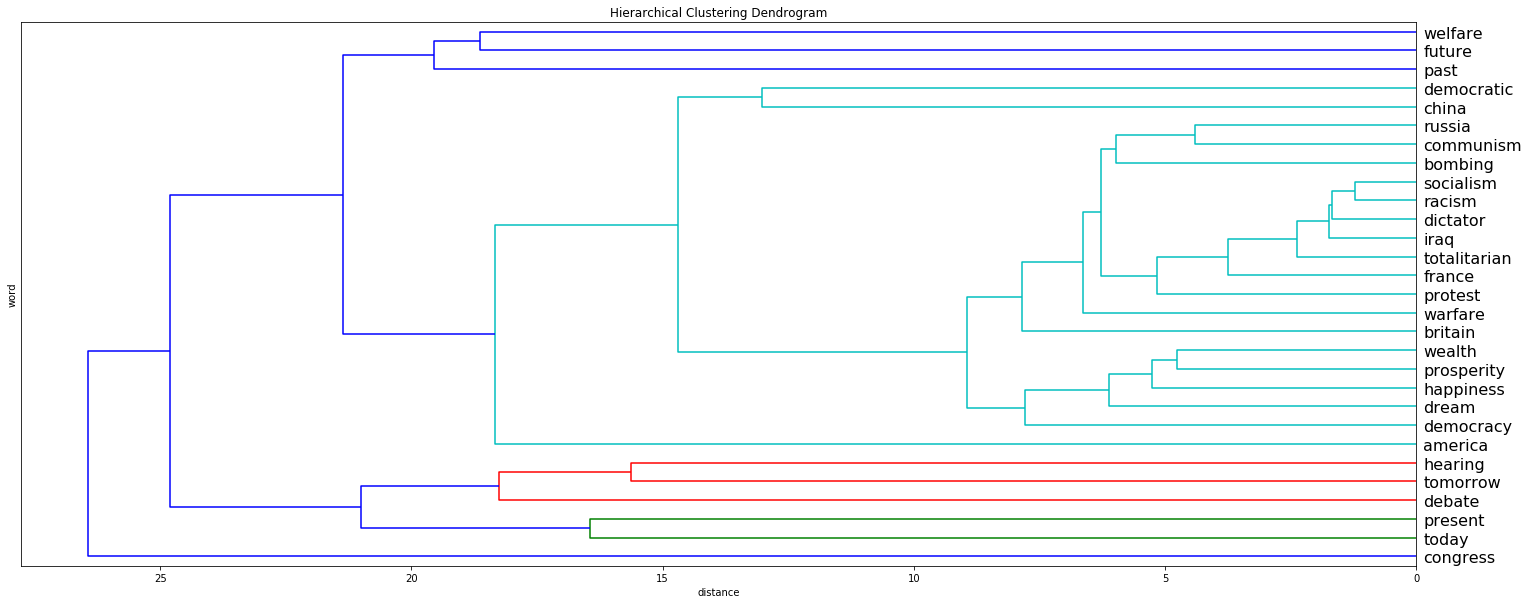

In [30]:
from matplotlib import pyplot as plt

l = links

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=16,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(keywords[v])
)
plt.show()


### Visualizing Abstract Relatedness

In [81]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [82]:
#%matplotlib inline

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

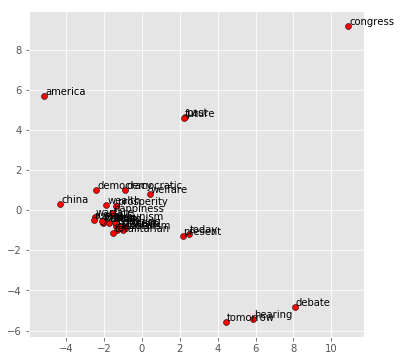

In [83]:
display_pca_scatterplot(congress_model.wv, keywords)

## Comparing Time with GENSIM

In [35]:
periodnames = sample_m['5yrperiod'].unique().tolist()
periodnames

[1970.0, 1980.0, 1975.0, 1965.0]

In [ ]:
women_context = [] # create an empty dummy variable

for period1 in periodnames:
    period_data = sample_m[sample_m['5yrperiod'] == period1] # select one period at a time
    print('mining ', period1)
    sentences = make_sentences(sample_m['speech']).copy() # break data into sentences for that period only 
    ####### tweak here after the first run to use the old data without generating it again
    period_model = gensim.models.Word2Vec( # make a gensim model for that data
        sentences = sentences,
        min_count = 2, 
        size = 100)  
    period_model.save('model-' + str(period1)) # save the model with the name of the period
    #period_model = gensim.models.Word2Vec.load('model-' + str(period1)) # to load a saved model
    ###########
    women_context_period = period_model.wv.most_similar("woman", topn = 1000) # extract the context of how women were talked about in that period
    women_context.append(women_context_period) # save the context of how women were talked about for later

mining  1970.0


#### Visualize it

In [ ]:
all_words = []
for i in range(5):
    words = [item[0] for item in women_context[i]][:10]
    all_words.append(words)

all_words2 = []
for list in all_words:
    for word in list:
        all_words2.append(word)

from numpy import linspace
from matplotlib import cm
colors = [ cm.jet(x) for x in linspace(.5, 2, 50) ]

%matplotlib inline

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from adjustText import adjust_text

# change the figure's size here
plt.figure(figsize=(5,5), dpi = 200)

# plt.annotate only plots one label per iteration, so we have to use a for loop 
for i in range(len(periodnames)):    # cycle through the period names
    
    xx = periodnames[i]        # on the x axis, plot the period name
    yyy = keyword_per_year[i]  # how many times was the keyword used that year?

    # for each period, one big black dot
    
    plt.scatter(                                           # plot dots
            xx, #x axis
            yyy, # y axis
            linewidth=1, 
            color = 'black',
            s = 10, # dot size
            alpha=0.2)  # dot transparency

                     
                     
    for j in range(10):     # cycle through the first ten words (you can change this variable)
        
        yy = [item[1] for item in women_context[i]][j]         # on the y axis, plot the distance -- how closely the word is related to the keyword
        txt = [item[0] for item in women_context[i]][j]        # grab the name of each collocated word
        colorindex = all_words2.index(txt)                     # this command keeps all dots for the same word the same color
        
        plt.scatter(                                           # plot dots
            xx, #x axis
            yy, # y axis
            linewidth=1, 
            color = colors[colorindex],
            s = 3, # dot size
            alpha=0.8)  # dot transparency

                                                                # make a label for each word
        plt.annotate(
                txt,
                (xx, yy),   
                size = 5,
                color = 'black', 
                alpha=0.8 # i've made the fonts transparent as well.  you could play with color and size if you wanted to. 
            )

# Code to help with overlapping labels -- may take a minute to run
adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xticks(rotation=90)

# Add titles
plt.title("Word Context Change for 'WOMAN' Over Time in Congress", fontsize=20, fontweight=0, color='Red')
plt.xlabel("period")
plt.ylabel("similarity of word")

